In [135]:
import random
import numpy as np
import matplotlib.pyplot as plt
from faker import Faker
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
import evaluate
fake = Faker()

In [136]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Fine-Tuning CodeT5-small for Commit Message Generation

## Introduction

After reviewing the available resources, I decided to fine-tune the **CodeT5-small** model for generating commit messages based on commit diffs. CodeT5 is a pre-trained encoder-decoder transformer model designed specifically for code understanding and generation tasks.

## Why CodeT5?

### CodeT5 Features

- **Unified Framework**: CodeT5 is designed to seamlessly support both code understanding and generation tasks. This makes it highly versatile for tasks such as code summarization, commit message generation, and more.

- **Identifier-Aware Pre-Training**: CodeT5 introduces a novel pre-training task that allows the model to distinguish code tokens that are identifiers (e.g., variable names, function names). This improves the model’s understanding of the code’s structure, making it particularly suitable for tasks where code semantics play a crucial role, such as generating commit messages based on diffs.

- **Multi-Task Learning**: CodeT5 supports multi-task learning, which allows it to handle tasks like PL-NL (Programming Language to Natural Language) and NL-PL (Natural Language to Programming Language) effectively. This is beneficial for generating text from code and vice versa, ensuring high-quality commit messages.

### Why CodeT5-small?

I chose to use the **CodeT5-small** variant because:
- It is a more efficient version of the model while still maintaining strong performance for code-related tasks.
- The smaller size allows for faster fine-tuning and deployment, making it ideal for quick iterations and testing in this context.


## Fine-Tuning Process

In this notebook, I will guide you through the **step-by-step process** of fine-tuning the CodeT5-small model for generating commit messages. The following steps will be covered:
1. **Data Preparation**: How to prepare commit diffs and corresponding messages for training.
2. **Model Fine-Tuning**: How to train the model on the prepared data.
3. **Metrics Evaluation**: Analyzing performance using metrics like BLEU, ROUGE, and METEOR.

## Conclusion

We will conclude by analyzing the **learning curve** and interpreting the **metric results** to evaluate the model's effectiveness in generating commit messages. Insights from these evaluations will guide us in further improving the model's performance.


# 1. Synthetic Commit Message Generator

## Introduction
This script generates a synthetic dataset of commit messages using a structured approach. It mimics real-world commit logs from software repositories, making it useful for tasks like training machine learning models on commit message prediction.

## How It Works
1. **Randomized Patterns**: The commit messages follow predefined patterns based on common commit types (e.g., `feat`, `fix`, `refactor`).
2. **Component and Action Selection**: Randomly selects a software component (e.g., `API`, `backend`) and an action (e.g., `add`, `fix`).
3. **Feature and Fix Description**: Populates commit messages with specific features, fixes, and refactoring descriptions.
4. **Uniqueness Handling**: Introduces variations to prevent duplicate messages.
5. **Dataset Creation**: Stores generated messages in a `Hugging Face Dataset` format.

## Example Output
- `feat(API): add user authentication`
- `fix(memory): fix race condition`
- `refactor(backend): improve structure`
- `test(config): add unit tests`
- `docs(logging): update README`

## Running the Code
Simply execute the function `create_synthetic_commits(1300)`, which generates 1300 commit messages and prints statistics on their uniqueness.

### - Total samples: **1300**
### - Unique messages: **~1300**
### - Most common messages: *(Example: `fix(API): fix memory leak`)*

This dataset is useful for **NLP tasks** in software engineering, **commit message completion**, and **automated code summarization**. 🚀


In [137]:
import random
from faker import Faker
from collections import Counter
from datasets import Dataset

fake = Faker()

def create_synthetic_commits(num_samples=1300):
    data = {'repo': [], 'diff': [], 'message': []}

    patterns = [
        ("feat({component}): {action} {feature}", ['component', 'action', 'feature']),
        ("fix({component}): {fix_description}", ['component', 'fix_description']),
        ("refactor({component}): {refactor_action}", ['component', 'refactor_action']),
        ("docs({component}): {doc_action}", ['component', 'doc_action']),
        ("test({component}): {test_action}", ['component', 'test_action']),
        ("perf({component}): optimize {optimized_part}", ['component', 'optimized_part']),
        ("chore({component}): {maintenance_action}", ['component', 'maintenance_action']),
        ("build({component}): {build_action}", ['component', 'build_action']),
        ("ci({component}): {ci_action}", ['component', 'ci_action'])
    ]

    components = [
        'API', 'database', 'UI', 'backend', 'tests', 'config',
        'memory', 'stream', 'cuda', 'ndarray', 'linalg',
        'gpu', 'kernel', 'cuda_kernel', 'linear_algebra',
        'optimizer', 'autograd', 'quantization', 'parallel',
        'multiprocessing', 'tensor_cores', 'memory_pool',
        'network', 'security', 'logging', 'serialization'
    ]

    actions = [
        'add', 'remove', 'update', 'implement', 'improve',
        'optimize', 'fix', 'correct', 'rewrite', 'restructure',
        'enhance', 'extend', 'simplify', 'clean up', 'reorganize',
        'migrate', 'deprecate', 'revise', 'upgrade', 'patch'
    ]

    features = [
        'user authentication', 'error handling', 'memory allocation',
        'API endpoint', 'database schema', 'test cases',
        'CUDA kernel', 'matrix operations', 'parallel processing',
        'logging system', 'configuration', 'input validation',
        'performance metrics', 'documentation', 'exception handling',
        'caching layer', 'data pipeline', 'security checks',
        'API gateway', 'load balancing', 'compression'
    ]

    fix_descriptions = [
        'memory leak', 'race condition', 'null pointer dereference',
        'buffer overflow', 'incorrect calculation', 'type mismatch',
        'deadlock', 'performance regression', 'incorrect API response',
        'missing initialization', 'unhandled exception',
        'thread safety issue', 'memory corruption', 'off-by-one error',
        'resource leak', 'incorrect validation', 'timeout handling'
    ]

    refactor_actions = [
        "improve structure", "simplify logic", "remove redundancy", "rewrite module",
        "reorganize functions", "split large function", "merge duplicate code"
    ]

    doc_actions = [
        "update README", "add inline comments", "improve documentation",
        "write tutorial", "add example usage", "clarify function behavior"
    ]

    test_actions = [
        "add unit tests", "update integration tests", "fix flaky test",
        "increase test coverage", "refactor test cases", "add benchmark tests"
    ]

    optimized_parts = [
        "memory allocation", "cache efficiency", "GPU utilization",
        "matrix multiplication", "vector operations", "parallel execution"
    ]

    maintenance_actions = [
        "remove deprecated code", "upgrade dependencies", "clean up files",
        "fix warnings", "migrate to new framework", "update style guide"
    ]

    build_actions = [
        "update dependencies", "fix build script", "add compiler flag",
        "update Makefile", "fix linking error", "add CI configuration"
    ]

    ci_actions = [
        "fix pipeline", "add test stage", "optimize workflow",
        "add deployment", "fix artifact upload", "add caching"
    ]

    # Generate messages
    seen_messages = set()

    for _ in range(num_samples):
        pattern, _ = random.choice(patterns)
        component = random.choice(components)

        message = pattern.format(
            component=component,
            action=random.choice(actions),
            feature=random.choice(features),
            fix_description=random.choice(fix_descriptions),
            refactor_action=random.choice(refactor_actions),
            doc_action=random.choice(doc_actions),
            test_action=random.choice(test_actions),
            optimized_part=random.choice(optimized_parts),
            maintenance_action=random.choice(maintenance_actions),
            build_action=random.choice(build_actions),
            ci_action=random.choice(ci_actions)
        )

        # Introduce randomness to increase uniqueness
        if random.random() > 0.8:
            message += f" ({random.choice(['v1', 'v2', 'final', fake.word()])})"

        if message not in seen_messages:
            seen_messages.add(message)
        else:
            # Slight variation if duplicate
            message += f" - {fake.word()}"

        # Store data
        data['repo'].append(f"github/{component.lower()}_{fake.word()}")
        data['diff'].append(f"diff --git a/src/{component.lower()}/file.c b/src/{component.lower()}/file.c")
        data['message'].append(message)

    return Dataset.from_dict(data)

# Run and check diversity
synthetic_train = create_synthetic_commits(1300)
messages = synthetic_train["message"]

print("Total samples:", len(messages))
print("Unique messages:", len(set(messages)))  # Should be close to 1450
print("Most common messages:", Counter(messages).most_common(5))


Total samples: 1300
Unique messages: 1300
Most common messages: [('fix(API): performance regression', 1), ('feat(API): update CUDA kernel', 1), ('chore(stream): fix warnings', 1), ('perf(backend): optimize GPU utilization', 1), ('chore(UI): remove deprecated code', 1)]


## 2. Dataset Preparation

This section involves creating and splitting the dataset for the project.

- **Dataset Creation:**
  - The synthetic dataset is generated using the `create_synthetic_commits` function, resulting in a total of 1500 samples.

- **Dataset Splitting:**
  - The dataset is split into training and test sets using a test size of 20%. This is done with a seed value of 42 to ensure reproducibility.

  - **Training Set:**
    - Contains 1200 samples (80% of the dataset).

  - **Validation Set:**
    - Contains 300 samples (20% of the dataset).


In [138]:
synthetic_full = create_synthetic_commits(1500)  # 1500 total samples
synthetic_split = synthetic_full.train_test_split(test_size=0.2, seed=42)

synthetic_train = synthetic_split["train"]  # 1200 samples (80%)
synthetic_val = synthetic_split["test"]  # 300 samples (20%)

## 3. Model Selection and Loading

In this section, we select and load a pre-trained model for fine-tuning on the commit message generation task.

- **Model Choice:**
  - The model chosen for this task is `Salesforce/codet5-small`. This model is well-suited for code-related tasks, such as generating commit messages.

- **Tokenizer and Model Loading:**
  - The `AutoTokenizer` and `AutoModelForSeq2SeqLM` are used to load the tokenizer and the model from the pre-trained `Salesforce/codet5-small` checkpoint.
  - The tokenizer is responsible for converting text into tokenized input for the model, while the model is used for sequence-to-sequence language modeling.



In [139]:
import torch

MODEL_NAME = "Salesforce/codet5-small"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)


## 4. Data Preprocessing

This section prepares the dataset for model fine-tuning by tokenizing inputs and labels.

- **Preprocessing Function:**
  - The `preprocess_function` processes each example in the dataset by:
    - **Preparing Inputs:**
      - Concatenates the repository name (`repo`) and the diff (`diff`) into a formatted string for the input text.

    - **Tokenizing Inputs:**
      - The input text is tokenized using the model's tokenizer, ensuring that the input sequences are truncated to a maximum length of 256 tokens and padded to the maximum length.

    - **Processing Labels:**
      - The commit messages (`message`) are tokenized similarly to the inputs, with a maximum length of 36 tokens.
      - Padding token IDs in the labels are replaced with `-100` to ensure they are ignored during the loss calculation.

- **Dataset Tokenization:**
  - The training and validation datasets are tokenized using the `preprocess_function` via the `.map()` method, removing original columns from the datasets and formatting them for use with PyTorch (`with_format("torch")`).


In [155]:
def preprocess_function(examples):
    """Simplified for synthetic data only"""
    # Prepare inputs
    inputs = [
        f"Repo: {repo}\nDiff:\n{diff}"
        for repo, diff in zip(examples["repo"], examples["diff"])
    ]

    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=256,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )

    # Process labels - keep as PyTorch tensors throughout
    labels = tokenizer(
        text_target=examples["message"],
        max_length=36,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )["input_ids"]

    # Replace padding token id with -100
    labels = torch.where(labels == tokenizer.pad_token_id, -100, labels)
    model_inputs["labels"] = labels

    return model_inputs


# Process datasets
tokenized_train = synthetic_train.map(
    preprocess_function,
    batched=True,
    remove_columns=synthetic_train.column_names
).with_format("torch")

tokenized_val = synthetic_val.map(
    preprocess_function,
    batched=True,
    remove_columns=synthetic_val.column_names
).with_format("torch")

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

## 5. Custom Callback for Metrics Logging

This section defines a custom callback class for logging training and evaluation metrics during model training.

- **PrintMetricsCallback Class:**
  - The `PrintMetricsCallback` inherits from `TrainerCallback` and overrides the `on_log` method to print training and evaluation metrics at each logging step.

- **Metrics Logging:**
  - The callback checks if the current process is the local process (`state.is_local_process_zero`) and if logs are available.

  - **Training Loss:**
    - If available, the training loss (`loss`) is printed with the current step number.

  - **Evaluation Metrics:**
    - If evaluation metrics are available, the callback prints:
      - **BLEU Score:** Measures the overlap between the n-grams in the predicted and reference sentences. A higher BLEU score indicates better translation quality.
      - **METEOR Score:** Evaluates translations based on precision, recall, synonymy, stemming, and word order. METEOR captures more semantic aspects than BLEU.
      - **Prefix Accuracy:** Measures how often the first few words of the generated text match the reference. This can be useful for evaluating early-stage sentence generation quality.
      - **ROUGE-2 Score:** Measures the overlap of bigrams between the generated and reference text. It’s useful for evaluating the quality of generated text in terms of richness and diversity.

  - **Learning Rate:**
    - Lastly, we print the (`learning_rate`).

- **Output Formatting:**
  - All collected metric lines are printed together, with a separator line of `=` characters to visually separate the outputs.


In [142]:
from transformers import TrainerCallback

class PrintMetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.is_local_process_zero and logs is not None:
            # Print training metrics
            output_lines = []

            if 'loss' in logs:
                output_lines.append(f"Step {state.global_step} - Training Loss: {logs['loss']:.4f}")

            # Print all evaluation metrics if available
            if 'eval_loss' in logs:
                output_lines.append("\nEvaluation Metrics:")
                output_lines.append(f"  - Validation Loss: {logs['eval_loss']:.4f}")

                # ROUGE metrics
                if 'eval_rouge1' in logs:
                    output_lines.append(f"  - ROUGE-1: {logs['eval_rouge1']:.4f}")
                if 'eval_rouge2' in logs:
                    output_lines.append(f"  - ROUGE-2: {logs['eval_rouge2']:.4f}")
                if 'eval_rougeL' in logs:
                    output_lines.append(f"  - ROUGE-L: {logs['eval_rougeL']:.4f}")

                # Other metrics
                if 'eval_bleu' in logs:
                    output_lines.append(f"  - BLEU: {logs['eval_bleu']:.4f}")
                if 'eval_meteor' in logs:
                    output_lines.append(f"  - METEOR: {logs['eval_meteor']:.4f}")
                if 'eval_exact_match' in logs:
                    output_lines.append(f"  - Exact Match: {logs['eval_exact_match']:.4f}")
                if 'eval_prefix_accuracy' in logs:
                    output_lines.append(f"  - Prefix Accuracy: {logs['eval_prefix_accuracy']:.4f}")

                # Add learning rate if available
                if 'learning_rate' in logs:
                    output_lines.append(f"\n  - Learning Rate: {logs['learning_rate']:.2e}")

            # Print all collected lines
            if output_lines:
                print("\n".join(output_lines) + "\n" + "="*50 + "\n")

## 6. Training Setup and Enhanced Metric Calculation

This section sets up the training parameters, metrics computation, and the training process for fine-tuning the model.

- **Training Arguments:**
  - **`Seq2SeqTrainingArguments`** defines the settings for training:
    - **Batch Size:** 8 for both training and evaluation.
    - **Learning Rate:** Set to `2e-5` for gradual model updates.
    - **Epochs:** 10 training epochs.
    - **Evaluation and Save Strategy:** Evaluates and saves the model every 100 steps.
    - **Logging:** Logs the training progress in the `./logs` directory.
    - **Model Selection:** Loads the best model based on the ROUGE-L score at the end of training.
    - **Gradient Accumulation:** Accumulates gradients over 2 steps to effectively train with a larger batch size without exceeding memory limits.
    - **Device Settings:** Training is done with `no_cuda=True` (i.e., on CPU) and `fp16=False` (no mixed precision).

- **Metric Calculation:**
  - The `compute_metrics` function computes several evaluation metrics. Please refer to the section above for the explanations.

- **Data Collator:**
  - **`DataCollatorForSeq2Seq`** is used to handle the padding and tokenization of the input data. It ensures consistent input formats for training and evaluation.

- **Trainer:**
  - The `Seq2SeqTrainer` is initialized with:
    - The model, training arguments, datasets, tokenizer, and custom metric computation.
    - A custom callback (`PrintMetricsCallback`) to log metrics during training.


In [143]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./commit-gen-2",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=2e-5,
    num_train_epochs=10,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="eval_rougeL",
    dataloader_num_workers=4,
    gradient_accumulation_steps=2,
    greater_is_better=True,
    fp16=False,
    no_cuda=True,
    predict_with_generate=True,
    generation_max_length=36,
    generation_num_beams=1,
    eval_steps=100,
    logging_steps=100,
)


rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")


# Enhanced Metric Calculation
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute all metrics
    rouge_results = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )
    bleu_score = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    meteor_score = meteor.compute(predictions=decoded_preds, references=decoded_labels)

    exact_matches = sum(
        1 for pred, ref in zip(decoded_preds, decoded_labels) if pred.strip() == ref.strip()
    ) / len(decoded_labels)

    prefix_matches = sum(
        1 for pred in decoded_preds if any(
            pred.strip().startswith(prefix)
            for prefix in ['feat', 'fix', 'refactor', 'docs', 'test']
        )
    ) / len(decoded_preds)

    return {
        "eval_loss": None,  # This will be added automatically by the Trainer
        **{f"eval_{k}": v for k, v in rouge_results.items()},
        "eval_bleu": bleu_score["bleu"],
        "eval_meteor": meteor_score["meteor"],
        "eval_exact_match": exact_matches,
        "eval_prefix_accuracy": prefix_matches,
    }

from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    padding=True,
    pad_to_multiple_of=8,
    max_length=256,
    label_pad_token_id=-100,
    return_tensors="pt",
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[PrintMetricsCallback()]
)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jasminavulovic/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jasminavulovic/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jasminavulovic/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/var/folders/dd/vd9k42ls7n5c72s8l82m7pz40000gn/T/ipykernel_45591/2375264750.py:88: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


## 7. Training and Evaluation

This section runs the training and evaluation processes and outputs the final benchmark results.

- **Training:**
  - The `trainer.train()` method is called to begin the training process using the specified training arguments, dataset, and model. The training process adjusts the model's weights over the specified number of epochs.

- **Evaluation:**
  - After training, the `trainer.evaluate()` method is called to evaluate the model's performance on the validation dataset. This provides metrics like loss and other evaluation scores defined in the `compute_metrics` function.

- **Benchmark Results:**
  - The final evaluation results, stored in `benchmark_results`, are printed out. These results provide a summary of the model's performance, including all the computed metrics (e.g., ROUGE, BLEU, METEOR, etc.).


In [144]:
train_history = trainer.train()
benchmark_results = trainer.evaluate()
print("\nFinal Benchmark Results:", benchmark_results)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fca592d1ab0>
Traceback (most recent call last):
  File "/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:27

Step,Training Loss,Validation Loss


/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max len

Step 100 - Training Loss: 4.5899



/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] =


Evaluation Metrics:
  - Validation Loss: 2.1826
  - ROUGE-1: 0.3117
  - ROUGE-2: 0.0921
  - ROUGE-L: 0.2996
  - BLEU: 0.3692
  - METEOR: 0.4630
  - Exact Match: 0.0000
  - Prefix Accuracy: 0.7167



/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] =

Step 200 - Training Loss: 1.8091



/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor fr


Evaluation Metrics:
  - Validation Loss: 1.3258
  - ROUGE-1: 0.3096
  - ROUGE-2: 0.0977
  - ROUGE-L: 0.2941
  - BLEU: 0.3870
  - METEOR: 0.4673
  - Exact Match: 0.0100
  - Prefix Accuracy: 0.4667



/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] =

Step 300 - Training Loss: 1.3529



/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor fr


Evaluation Metrics:
  - Validation Loss: 1.0884
  - ROUGE-1: 0.2786
  - ROUGE-2: 0.0885
  - ROUGE-L: 0.2703
  - BLEU: 0.3835
  - METEOR: 0.4576
  - Exact Match: 0.0000
  - Prefix Accuracy: 0.8433



/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] =

Step 400 - Training Loss: 1.1655



/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor fr


Evaluation Metrics:
  - Validation Loss: 0.9860
  - ROUGE-1: 0.2994
  - ROUGE-2: 0.1029
  - ROUGE-L: 0.2916
  - BLEU: 0.3881
  - METEOR: 0.4170
  - Exact Match: 0.0100
  - Prefix Accuracy: 0.1633



/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] =

Step 500 - Training Loss: 1.0682



/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] =


Evaluation Metrics:
  - Validation Loss: 0.9410
  - ROUGE-1: 0.2758
  - ROUGE-2: 0.0856
  - ROUGE-L: 0.2712
  - BLEU: 0.3798
  - METEOR: 0.4579
  - Exact Match: 0.0067
  - Prefix Accuracy: 0.8067



/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] =

Step 600 - Training Loss: 1.0345



/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] =


Evaluation Metrics:
  - Validation Loss: 0.9216
  - ROUGE-1: 0.2414
  - ROUGE-2: 0.0668
  - ROUGE-L: 0.2413
  - BLEU: 0.3550
  - METEOR: 0.4525
  - Exact Match: 0.0033
  - Prefix Accuracy: 0.2100



/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max len

Step 700 - Training Loss: 0.9864



/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor fr


Evaluation Metrics:
  - Validation Loss: 0.9153
  - ROUGE-1: 0.2586
  - ROUGE-2: 0.0666
  - ROUGE-L: 0.2575
  - BLEU: 0.3709
  - METEOR: 0.4446
  - Exact Match: 0.0100
  - Prefix Accuracy: 0.7433



/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/Users/jasminavulovic/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] =


Evaluation Metrics:
  - Validation Loss: 0.9129
  - ROUGE-1: 0.2611
  - ROUGE-2: 0.0694
  - ROUGE-L: 0.2589
  - BLEU: 0.3721
  - METEOR: 0.4476
  - Exact Match: 0.0067
  - Prefix Accuracy: 0.7700


Final Benchmark Results: {'eval_loss': 0.9129166007041931, 'eval_rouge1': 0.26105172605172666, 'eval_rouge2': 0.06936447811447807, 'eval_rougeL': 0.2588596588596592, 'eval_rougeLsum': 0.2590016372516377, 'eval_bleu': 0.372124427563325, 'eval_meteor': 0.44756966925335706, 'eval_exact_match': 0.006666666666666667, 'eval_prefix_accuracy': 0.77, 'eval_runtime': 116.255, 'eval_samples_per_second': 2.581, 'eval_steps_per_second': 0.327, 'epoch': 10.0}


## 8. Loss Visualization

This section plots the training and evaluation losses over time to visualize the model's progress during training.

- **Logging History:**
  - The `trainer.state.log_history` contains the logged information during training, including both training and evaluation losses at each logging step.

- **Loss Extraction:**
  - The `train_loss` list is created by extracting the "loss" values from the log history.
  - The `eval_loss` list is created by extracting the "eval_loss" values from the log history.

- **Plotting Losses:**
  - Using `matplotlib`, the training and evaluation losses are plotted on the same graph with labels for each curve.
  - A legend is added to differentiate between the training loss and evaluation loss curves.


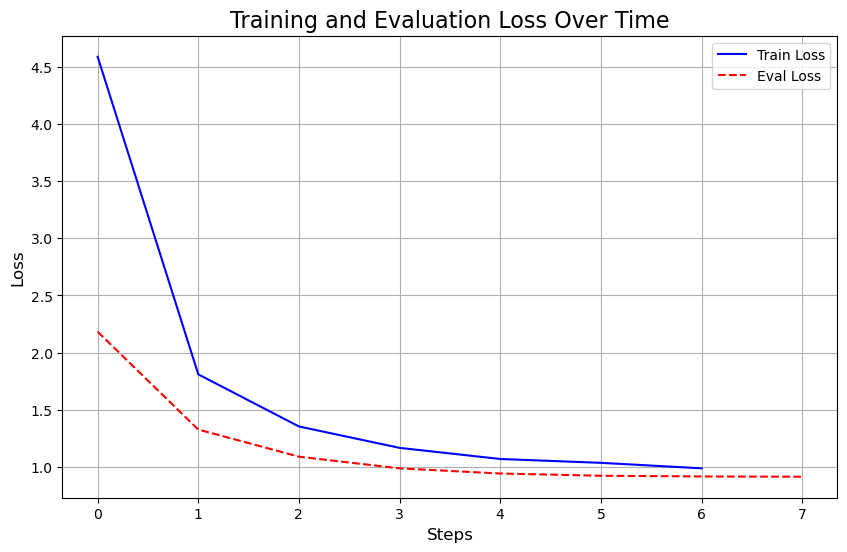

In [160]:
import matplotlib.pyplot as plt
# Extract loss data
log_history = trainer.state.log_history
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]

# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Train Loss", color='b', linestyle='-')
plt.plot(eval_loss, label="Eval Loss", color='r', linestyle='--')

# Customize plot
plt.title("Training and Evaluation Loss Over Time", fontsize=16)
plt.xlabel("Steps", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## 8.1 Interpreting Loss Results:
- **General Trend:** The training loss steadily decreases over time. It starts from around 4.59 at the first checkpoint (step 100), and then it gradually reduces to approx 0.91 by step 750. This indicates that the model is learning, and the training process is going well.
- **Observation:** The loss reduction is consistent but not overly steep, which says that the model is converging steadily. The amount of loss reduction seems reasonable, and we see no abrupt jumps or stalls, which means stable training.

## Evaluation Loss:
- **General Trend:** The evaluation loss follows a similar pattern to the training loss, steadily decreasing from 2.18 at step 100 to 0.91 at step 750. The evaluation loss starts higher than the training loss, which is expected as the model has not yet been optimized for validation data.
- **Observation:** The evaluation loss is consistently lower than the training loss, and the gap seems to narrow over time. This indicates that the model is not overfitting and is improving its generalization on unseen data. The steady decrease in eval loss says that our training has been effective.

## Overall Performance Evaluation:
- **Is it good or bad?**
    - The model shows positive progress in both training and evaluation. The consistent reduction in loss indicates that the model is learning.
    - Evaluation loss is decreasing, which is a good sign of the model’s generalization ability on unseen data.
    - The model isn't overfitting at this point (we can see this in the narrowing gap between training and evaluation losses).
    - Training loss is relatively higher than eval loss at first, which is typical early on, and both losses converge as training progresses.

In conclusion, the model is performing well with steady improvements across the training and evaluation metrics. It seems to be learning and generalizing effectively, with no obvious signs of overfitting or poor performance. It’s on a good track.

However, it still did learn on a small amount of synthetic data, which is the biggest limitation.

In [161]:
# Print the log history containing training and validation loss
for log in trainer.state.log_history:
    if 'loss' in log or 'eval_loss' in log:
        print(log)

{'loss': 4.5899, 'grad_norm': 3.3043837547302246, 'learning_rate': 2e-05, 'epoch': 1.3333333333333333, 'step': 100}
{'eval_loss': 2.182636022567749, 'eval_rouge1': 0.3116821141821148, 'eval_rouge2': 0.09205615680615672, 'eval_rougeL': 0.2996458078958086, 'eval_rougeLsum': 0.3001898841898848, 'eval_bleu': 0.36916405539999375, 'eval_meteor': 0.46296235104976197, 'eval_exact_match': 0.0, 'eval_prefix_accuracy': 0.7166666666666667, 'eval_runtime': 138.4395, 'eval_samples_per_second': 2.167, 'eval_steps_per_second': 0.274, 'epoch': 1.3333333333333333, 'step': 100}
{'loss': 1.8091, 'grad_norm': 3.6181418895721436, 'learning_rate': 1.6923076923076924e-05, 'epoch': 2.6666666666666665, 'step': 200}
{'eval_loss': 1.3257628679275513, 'eval_rouge1': 0.30959403559403625, 'eval_rouge2': 0.0976904761904761, 'eval_rougeL': 0.2940618085618093, 'eval_rougeLsum': 0.29355363155363223, 'eval_bleu': 0.3869527354848642, 'eval_meteor': 0.46730895924234744, 'eval_exact_match': 0.01, 'eval_prefix_accuracy': 0.4

## 8.2 Interpreting Metrics Results
1. **BLEU**:
    * BLEU focuses on exact n-gram matches, and the scores of 0.35 to 0.39 say that the model is effectively learning to generate text that aligns well with the reference. While there's room to refine this further, the increase in BLEU scores over time shows that the model is improving in its ability to produce more accurate and fluent outputs.

2. **METEOR**:
    * METEOR combines diverse factors like n-gram precision, synonymy, and stemming. The scores ranging from 0.42 to 0.47 show that the model is already doing a solid job of generating semantically meaningful and contextually relevant text. The consistent scores also indicate that the model is becoming more adept at understanding the nuances of language, which is a great sign of progress.

3. **ROUGE-2**:
    * ROUGE-2 measures the overlap of bigrams between the predicted and reference texts. While the values range from 0.066 to 0.102, the model is showing a steady increase over time. Like in the previous case, this gradual improvement suggests that the model is learning to capture better word pairs, and with more training, we can expect this to continue to improve.


4. **Exact-Prefix-Matching**:
    * This metric seems to be struggling the most, as we can tell by the constant jumps. However, near the end of the training, it begins to stabilize. It reaches a solid-enough number as well.

The main reason why the model may be struggling is due to the synthetic data, as well as the small amount to train on. Even with these big limitations, the model seems to learn well. Providing the model with better data to train on will yield even better results. Most importantly, we do not overfit, we have a steady decrease in loss, and we converge well. The generalization on this synthetic data seems decent, as well as the overall fine-tuning.


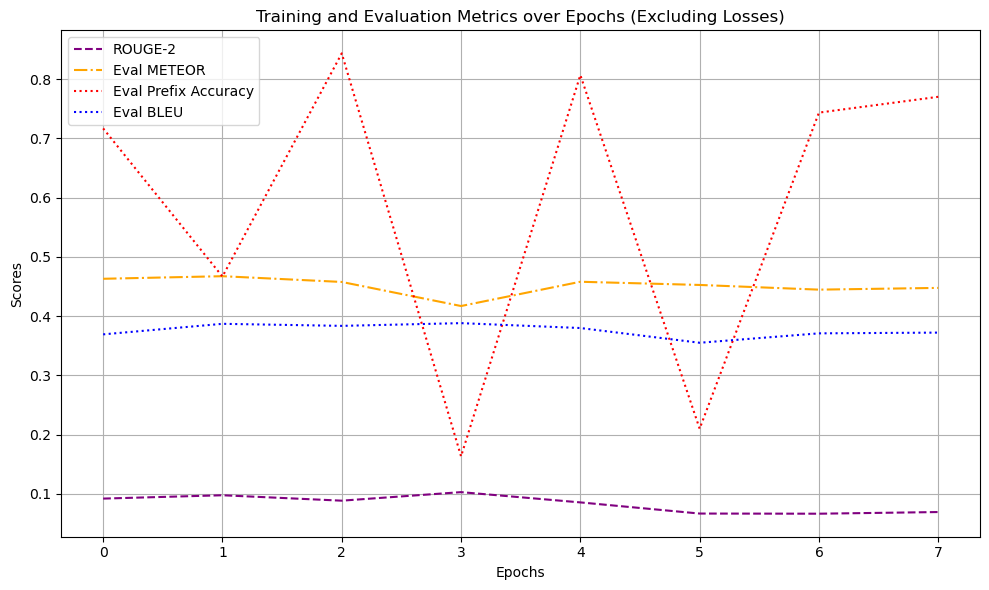

In [164]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
rouge2 = [x["eval_rouge2"] for x in log_history if "eval_rouge2" in x]
eval_meteor = [x["eval_meteor"] for x in log_history if "eval_meteor" in x]
eval_bleu = [x["eval_bleu"] for x in log_history if "eval_bleu" in x]
eval_prefix_accuracy = [x["eval_prefix_accuracy"] for x in log_history if "eval_prefix_accuracy" in x]

# Plotting the metrics
plt.figure(figsize=(10, 6))
plt.plot(rouge2, label="ROUGE-2", linestyle="--", color='purple')
plt.plot(eval_meteor, label="Eval METEOR", linestyle='-.', color='orange')
plt.plot(eval_prefix_accuracy, label="Eval Prefix Accuracy", linestyle=':', color='red')
plt.plot(eval_bleu, label="Eval BLEU", linestyle='dotted', color='blue')

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("Scores")
plt.title("Training and Evaluation Metrics over Epochs (Excluding Losses)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()
